import libraries

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from utils import load_json, load_pickle, pickle_data

import torch

mkdir -p failed for path /afs/csail.mit.edu/u/k/klingmin/.config/matplotlib: [Errno 13] Permission denied: '/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-6z9fp5ul because there was an issue with the default path (/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Settings

In [2]:
baseline_folder = "../FP_prediction/baseline_models/best_models"
MIST_folder = "../FP_prediction/mist/best_models/"
cache_folder = "./cache"
plots_folder = os.path.join(cache_folder, "correlation_plots")
if not os.path.exists(plots_folder): os.makedirs(plots_folder)

dataset_mapping = {"canopus": "NPLIB1", 
                   "massspecgym": "MassSpecGym",
                   "nist2023": "NIST2023"}

model_mapping = {"binned": "B-MLP",
                 "MS" : "MS-T",
                 "formula": "CF-T",
                 "MIST": "MIST"}

splits_mapping = {"scaffold_vanilla": "Scaffold-split",
                  "inchikey_vanilla": "InChIKey-split",
                  "random": "Random-split"}

models = ["MS", "formula", "binned", "MIST"]

To consolidate the best performance for each setting

In [3]:
# Manually add in (hack)

all_folders = []
all_test_performances = {"loss": {}, "jaccard": {}} 

for folder in [baseline_folder, MIST_folder]:

    for dataset in os.listdir(folder):
        subsubfolder = os.path.join(folder, dataset)
        for checkpoint in os.listdir(subsubfolder):
            if "wo_aux" in checkpoint: continue
            all_folders.append(os.path.join(subsubfolder, checkpoint))

for f in all_folders:

    try:
        expt_name = f.split("/")[-1]
        test_performance = load_json(os.path.join(f, "test_performance.json"))
        for k, v in test_performance.items():
            if k == "threshold": continue 
            if k == "jaccard_subset": continue
            all_test_performances[k][expt_name] = round(v, 5)
    except Exception as e:
        print(e)
        continue

Format the table

In [4]:
results = pd.DataFrame.from_dict(all_test_performances)
results = results.reset_index()
results = results.rename(columns = {"index": "expt_name"})
results.loc[:, "dataset"] = results.loc[:, "expt_name"].apply(lambda x: x.split("_")[0]) 
results.loc[:, "meta"] = results.loc[:, "expt_name"].apply(lambda x: "meta" in x) 
results.loc[:, "model"] = results.loc[:, "expt_name"].apply(lambda x: x.split("_")[1]) 
results.loc[:, "split"] = results.loc[:, "expt_name"].apply(lambda x: "_".join(x.split("_")[-2:]).replace("4096_", "")) 

results = results.loc[:, ["dataset", "model", "split", "meta", "loss", "jaccard"]]

results = results.sort_values(by = 'split', ascending = False)
results = results.sort_values(by = 'model', ascending = False)
results = results.sort_values(by = 'dataset', ascending = False)

Consolidate best results in a table

In [14]:
best_baselines_folder = "../FP_prediction/baseline_models/best_models/"
best_MIST_folder = "../FP_prediction/mist/best_models/"

all_folders = []
all_test_performances = {"loss": {}, "jaccard": {}} 

for folder in [best_baselines_folder, best_MIST_folder]:

    for dataset in os.listdir(folder):
        subfolder = os.path.join(folder, dataset)
        for checkpoint in os.listdir(subfolder):
            all_folders.append(os.path.join(subfolder, checkpoint))

for f in all_folders:

    try:
        expt_name = f.split("/")[-1]
        test_performance = load_json(os.path.join(f, "test_performance.json"))
        for k, v in test_performance.items():
            if k == "threshold": continue 
            if k == "jaccard_subset": continue
            all_test_performances[k][expt_name] = round(v, 3)
    except Exception as e:
        print(e)
        continue

In [15]:
results = pd.DataFrame.from_dict(all_test_performances)
results = results.reset_index()
results = results.rename(columns = {"index": "expt_name"})
results.loc[:, "dataset"] = results.loc[:, "expt_name"].apply(lambda x: x.split("_")[0]) 
results.loc[:, "meta"] = results.loc[:, "expt_name"].apply(lambda x: "meta" in x) 
results.loc[:, "model"] = results.loc[:, "expt_name"].apply(lambda x: x.split("_")[1]) 
results.loc[:, "split"] = results.loc[:, "expt_name"].apply(lambda x: "_".join(x.split("_")[-2:]).replace("4096_", "")) 

results = results.loc[:, ["dataset", "model", "split", "meta", "loss", "jaccard"]]

results = results.sort_values(by = 'split', ascending = False)
results = results.sort_values(by = 'model', ascending = False)
results = results.sort_values(by = 'dataset', ascending = False)

In [32]:
results.query("dataset == 'NIST2023' and model == 'MIST'")

,dataset,model,split,meta,loss,jaccard
69,NIST2023,MIST,vanilla_sieved,False,0.056,0.257
70,NIST2023,MIST,LS_sieved,True,0.046,0.290
68,NIST2023,MIST,random_sieved,False,0.015,0.621
71,NIST2023,MIST,scaffold_vanilla,True,0.061,0.255
74,NIST2023,MIST,LS,True,0.049,0.214
72,NIST2023,MIST,random,True,0.016,0.622
67,NIST2023,MIST,vanilla_sieved,False,0.045,0.304
73,NIST2023,MIST,inchikey_vanilla,False,0.048,0.301


Get pearson and spearman correlation between model's prediction

In [11]:
consolidated_results_path = os.path.join(plots_folder, "models_correlation.pkl")

if not os.path.exists(consolidated_results_path):
        
    all_folders_sieved = [f for f in all_folders if "sieved" not in f and "sampled" not in f]
    consolidated_performance = [] 

    for dataset in ["canopus", "massspecgym", "nist2023"]:

        for split in ["scaffold_vanilla", "inchikey_vanilla", "random"]:
            
            print(f"Processing dataset: {dataset} and split: {split} now")
            selected_folders = [f for f in all_folders_sieved if dataset in f and split in f]
            test_results_consolidated = {} 

            for f in selected_folders:

                model = f.split("/")[-1].split("_")[1]


                test_results = load_pickle(os.path.join(f, "test_results.pkl"))
                for k, v in test_results.items():
                    if type(k) == torch.Tensor: k = k.item()
                    k = str(k).strip()
                    if k not in test_results_consolidated: test_results_consolidated[k] = {}
                    test_results_consolidated[k][model] = v["loss"]
            
            for m_1,m_2 in itertools.combinations(models, 2):

                m_1_results = [v[m_1] for v in test_results_consolidated.values() if len(v) == 4]
                m_2_results = [v[m_2] for v in test_results_consolidated.values() if len(v) == 4]

                pearson_results = stats.pearsonr(m_1_results, m_2_results)
                pearson_stats, person_p_value = pearson_results.statistic, pearson_results.pvalue

                spearman_results = stats.spearmanr(m_1_results, m_2_results)
                spearman_stats,spearman_p_value = spearman_results.statistic, spearman_results.pvalue

                consolidated_performance.append([dataset, split, m_1, m_2, pearson_stats, person_p_value, spearman_stats, spearman_p_value])

    pickle_data(consolidated_performance, consolidated_results_path)

consolidated_performance = load_pickle(consolidated_results_path)
consolidated_performance = pd.DataFrame(consolidated_performance)

Plot the heat map

<Figure size 1000x800 with 0 Axes>

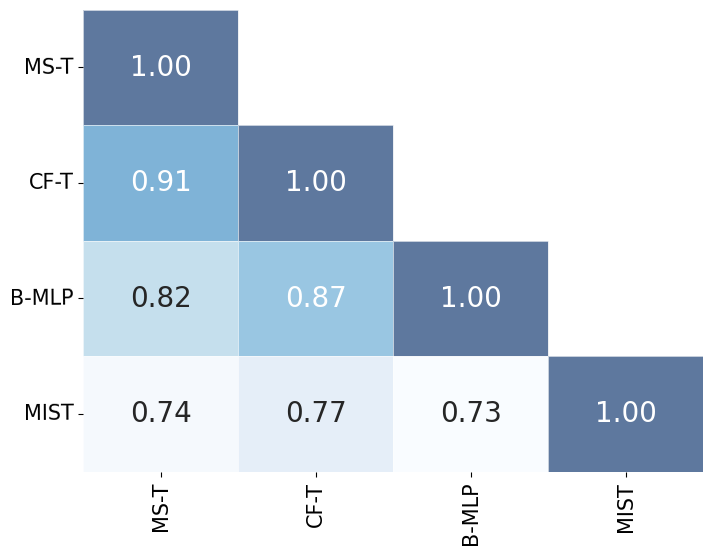

<Figure size 1000x800 with 0 Axes>

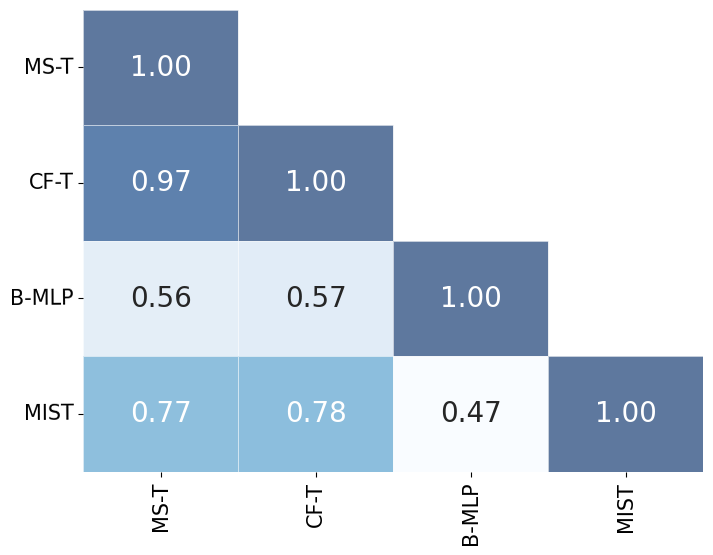

<Figure size 1000x800 with 0 Axes>

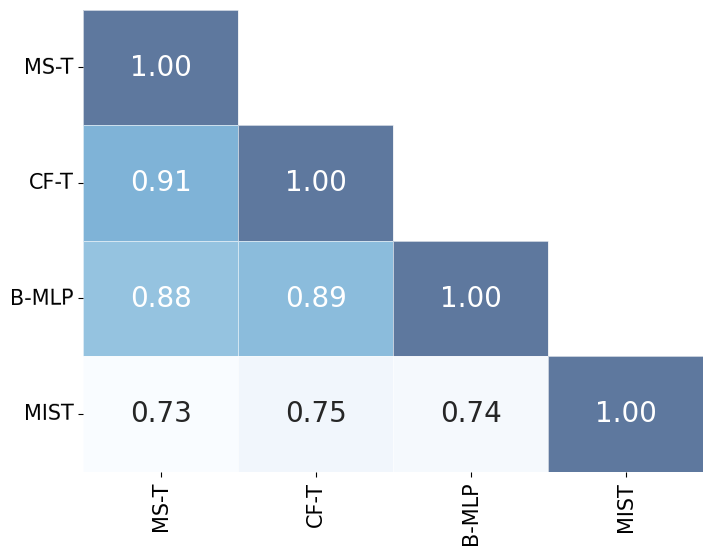

<Figure size 1000x800 with 0 Axes>

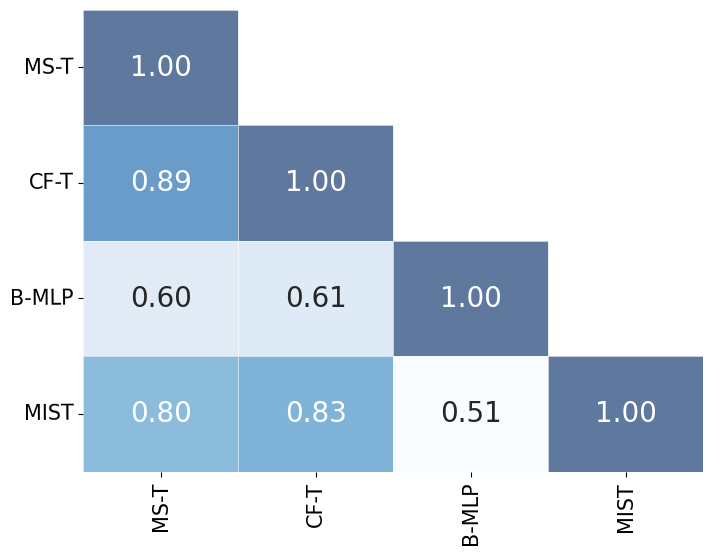

<Figure size 1000x800 with 0 Axes>

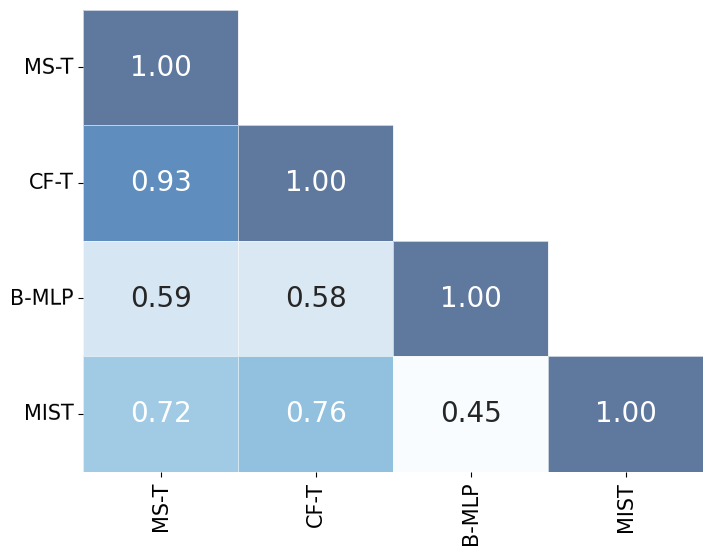

<Figure size 1000x800 with 0 Axes>

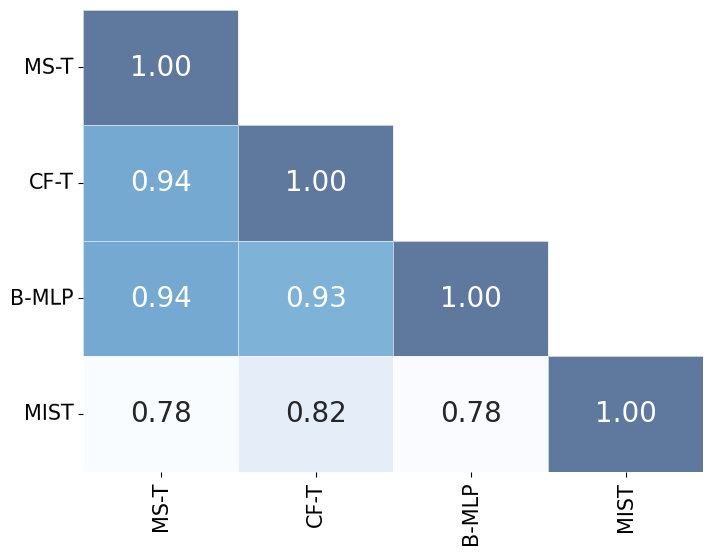

<Figure size 1000x800 with 0 Axes>

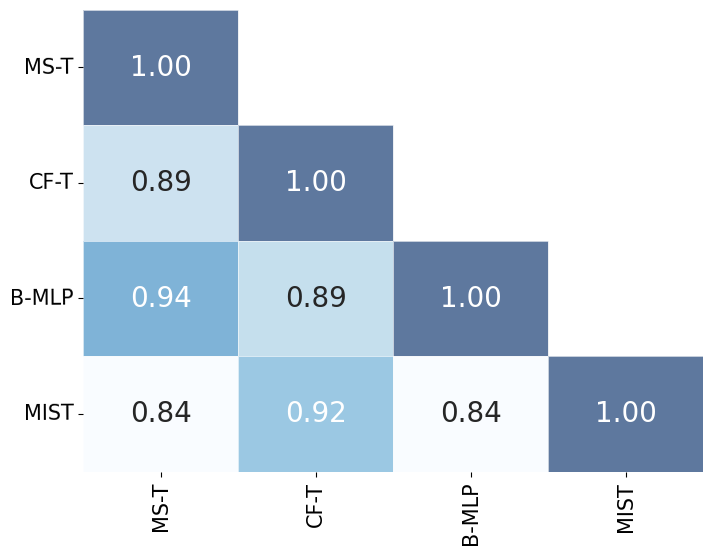

<Figure size 1000x800 with 0 Axes>

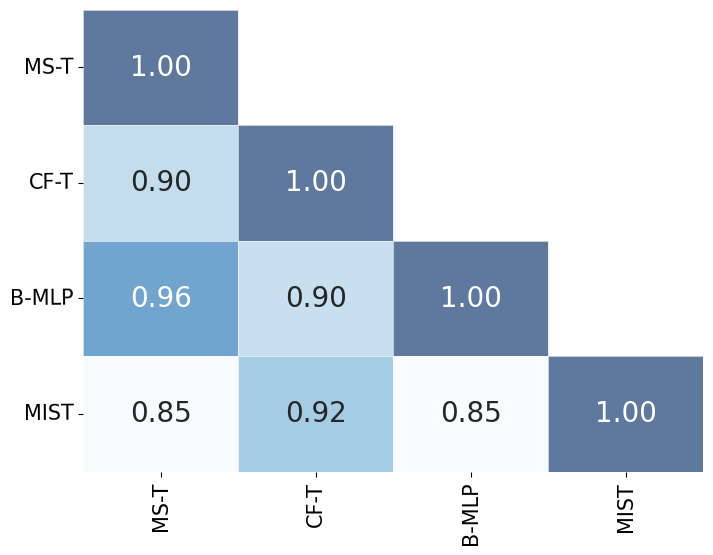

<Figure size 1000x800 with 0 Axes>

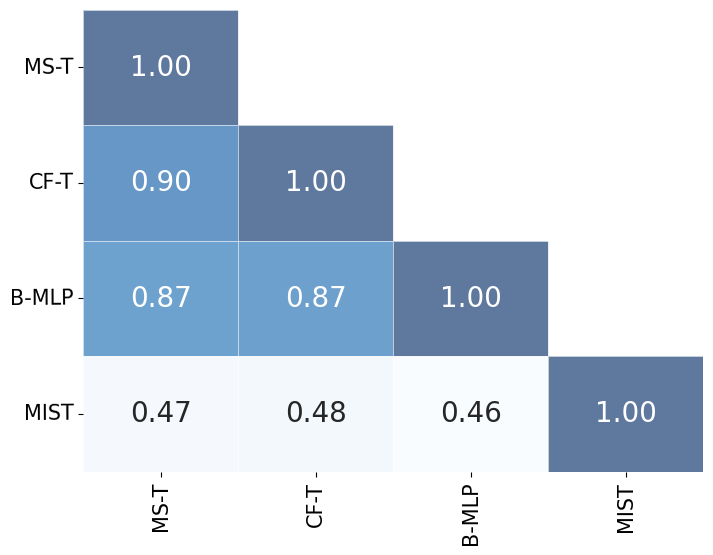

In [23]:
for dataset in ["canopus", "massspecgym", "nist2023"]:

    for split in ["scaffold_vanilla", "inchikey_vanilla", "random"]:

        current_performance = consolidated_performance.loc[consolidated_performance.iloc[:, 0] == dataset, :]
        current_performance = current_performance.loc[current_performance.iloc[:, 1] == split, :]

        consolidate_correlation = [[0 for _ in range(len(models))] for _ in range(len(models))]
        plt.figure(figsize=(10, 8))  # Adjust figure size as needed

        for i in range(len(models)):

            m1 = models[i] 

            for j in range(i, len(models)):
                
                m2 = models[j]
                if i == j: 
                    consolidate_correlation[i][j] = 1.0
                    continue 
                
                stats = current_performance.loc[current_performance.iloc[:, 2] == m1, :]
                stats = stats.loc[stats.iloc[:, 3] == m2, :].values[0][4]
                consolidate_correlation[i][j] = stats
                consolidate_correlation[j][i] = stats

        plt.figure(figsize=(8, 6))
        
        mask = np.zeros_like(consolidate_correlation, dtype=bool)
        mask[np.triu_indices_from(mask, k=1)] = True
                
        heatmap = sns.heatmap(consolidate_correlation, annot=True, fmt=".2f", cmap="Blues", alpha = 0.65, 
                              linewidths=.5, 
                              annot_kws={"size": 20}, 
                              cbar_kws={'shrink': 1.0},
                              mask = mask, cbar = False)
        
        models_ = [model_mapping[m] for m in models]
        heatmap.set_xticklabels(models_, rotation = 90, fontsize = 15)
        heatmap.set_yticklabels(models_, rotation = 0.4, fontsize = 15)
        dataset_ = dataset_mapping[dataset]
        split_ = splits_mapping[split]

        # plt.title(f"{dataset_} ({split_}) ")
        
        plt.savefig(os.path.join(plots_folder, f"{dataset}_{split}_pearson.jpg"), bbox_inches = "tight")
        plt.show()

<Figure size 1000x800 with 0 Axes>

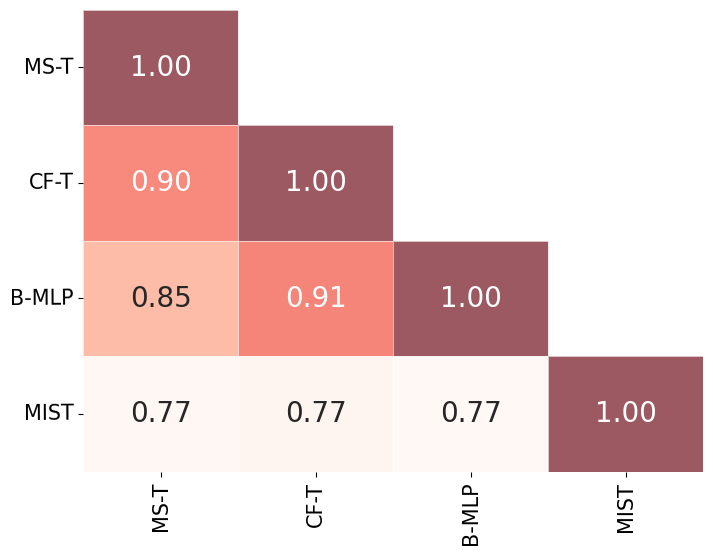

<Figure size 1000x800 with 0 Axes>

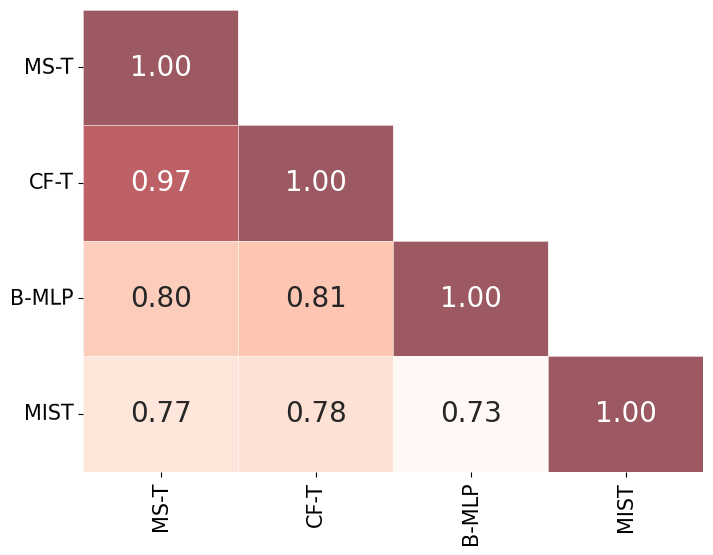

<Figure size 1000x800 with 0 Axes>

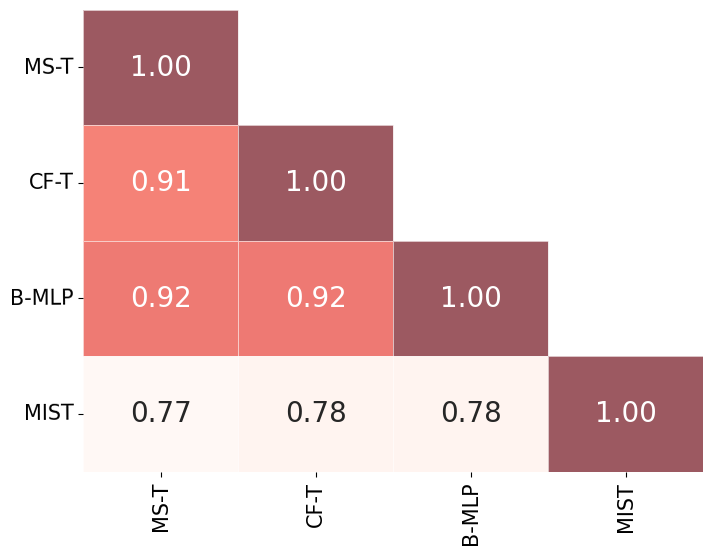

<Figure size 1000x800 with 0 Axes>

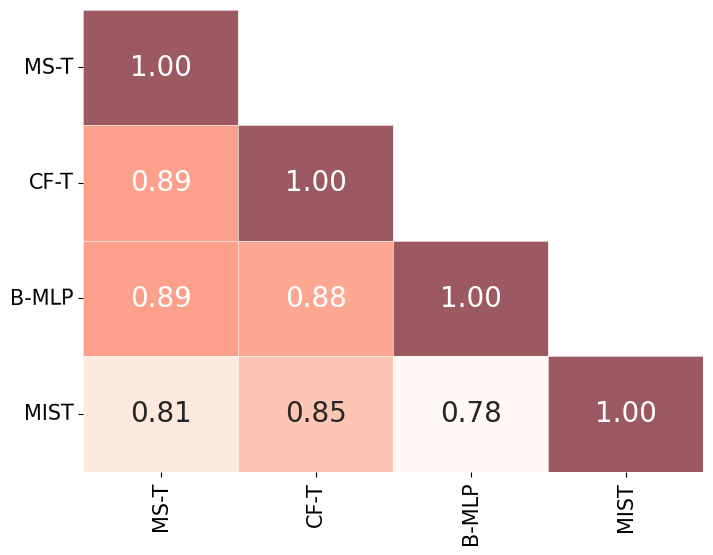

<Figure size 1000x800 with 0 Axes>

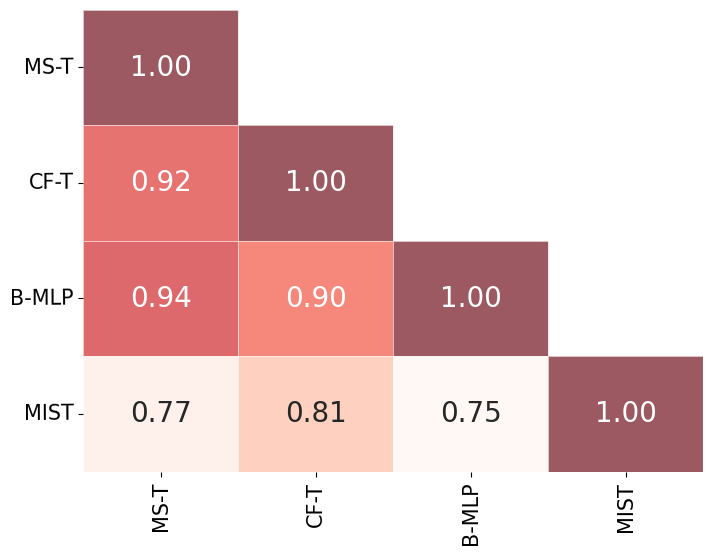

<Figure size 1000x800 with 0 Axes>

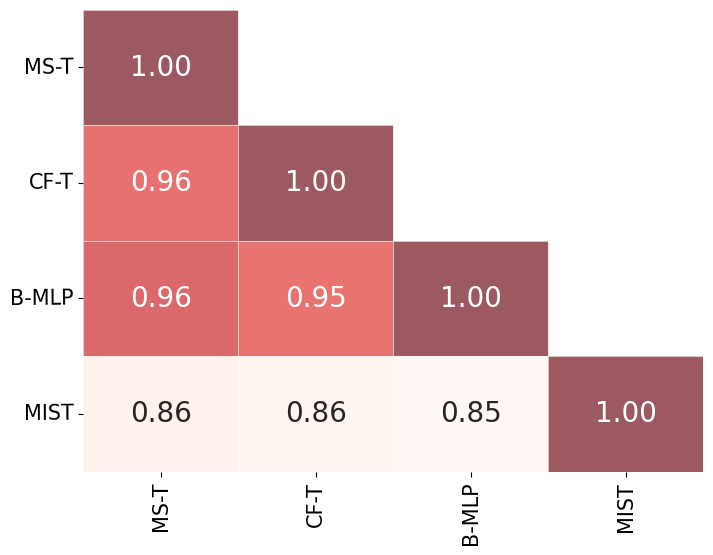

<Figure size 1000x800 with 0 Axes>

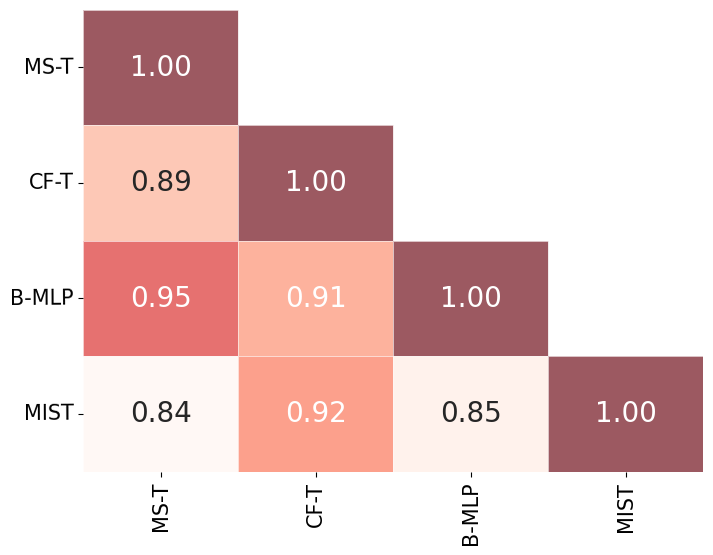

<Figure size 1000x800 with 0 Axes>

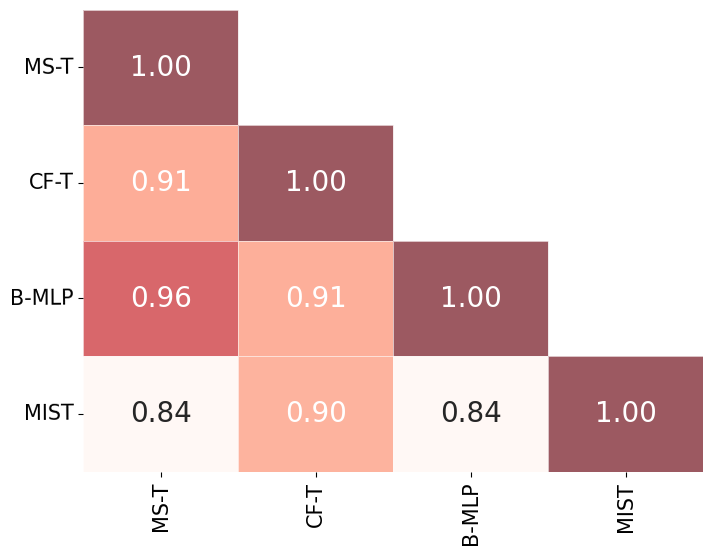

<Figure size 1000x800 with 0 Axes>

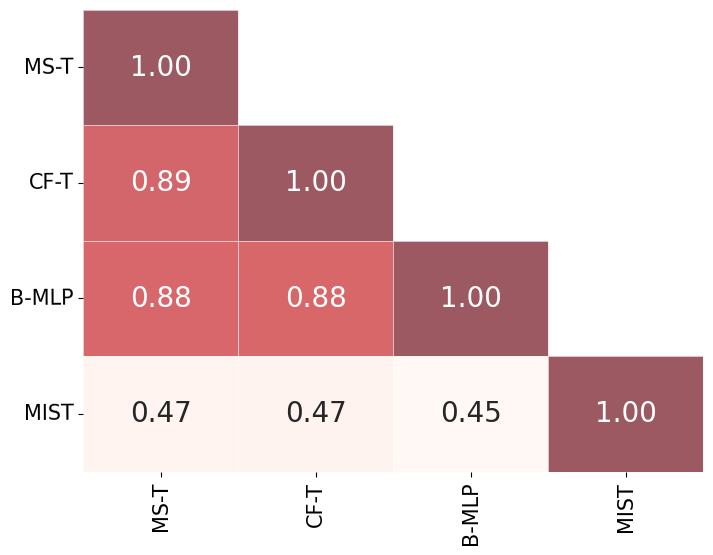

In [21]:
for dataset in ["canopus", "massspecgym", "nist2023"]:

    for split in ["scaffold_vanilla", "inchikey_vanilla", "random"]:

        current_performance = consolidated_performance.loc[consolidated_performance.iloc[:, 0] == dataset, :]
        current_performance = current_performance.loc[current_performance.iloc[:, 1] == split, :]

        consolidate_correlation = [[0 for _ in range(len(models))] for _ in range(len(models))]
        plt.figure(figsize=(10, 8))  # Adjust figure size as needed

        for i in range(len(models)):

            m1 = models[i] 

            for j in range(i, len(models)):
                
                m2 = models[j]
                if i == j: 
                    consolidate_correlation[i][j] = 1.0
                    continue 
                
                stats = current_performance.loc[current_performance.iloc[:, 2] == m1, :]
                stats = stats.loc[stats.iloc[:, 3] == m2, :].values[0][6]
                consolidate_correlation[i][j] = stats
                consolidate_correlation[j][i] = stats

        plt.figure(figsize=(8, 6))
        
        mask = np.zeros_like(consolidate_correlation, dtype=bool)
        mask[np.triu_indices_from(mask, k=1)] = True
                
        heatmap = sns.heatmap(consolidate_correlation, annot=True, fmt=".2f", cmap="Reds", alpha = 0.65, 
                              linewidths=.5, 
                              annot_kws={"size": 20}, 
                              cbar_kws={'shrink': 1.0},
                              mask = mask, cbar = False)
        
        models_ = [model_mapping[m] for m in models]
        heatmap.set_xticklabels(models_, rotation = 90, fontsize = 15)
        heatmap.set_yticklabels(models_, rotation = 0.4, fontsize = 15)
        dataset_ = dataset_mapping[dataset]
        split_ = splits_mapping[split]

        # plt.title(f"Spearman Rank Correlation for {dataset_} ({split_})")
        plt.savefig(os.path.join(plots_folder, f"{dataset}_{split}_spearman.jpg"), bbox_inches = "tight")
        plt.show()
